In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

In [62]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
sns.set() #s
import warnings
warnings.simplefilter(action="ignore")

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [66]:
df = pd.read_excel(r"C:\Users\Omast\OneDrive\Desktop\monthly_sales_data .xlsx")

### View the first 5and last five rows of the dataset

In [69]:
df.head()

,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
0,Sports,2002-01-01,108592,2002,1,Xbox,1,0
1,RPG,2002-02-01,129387,2002,4,Nintendo,0,0
2,Sports,2002-03-01,114777,2002,4,PC,0,0
3,Sports,2002-04-01,71738,2002,0,Nintendo,0,0
4,Simulation,2002-05-01,142512,2002,2,PlayStation,0,0


In [71]:
df.tail()

,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
259,RPG,2023-08-01,132693,2023,1,PC,0,0
260,Simulation,2023-09-01,143373,2023,4,Nintendo,0,0
261,Simulation,2023-10-01,126410,2023,6,Nintendo,0,1
262,Simulation,2023-11-01,91200,2023,2,Nintendo,0,0
263,RPG,2023-12-01,159721,2023,4,Nintendo,1,0


### Understanding the shape of the dataset

In [74]:
df.shape

(264, 8)

### Check the data types of the columns for the dataset

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Category       264 non-null    object        
 1   Month          264 non-null    datetime64[ns]
 2   Monthly Sales  264 non-null    int64         
 3   Year           264 non-null    int64         
 4   DayOfWeek      264 non-null    int64         
 5   Platform       264 non-null    object        
 6   Holiday        264 non-null    int64         
 7   Promotion      264 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 16.6+ KB


### Checking for missing values

In [80]:
df.isnull().sum() # check for null values

Category         0
Month            0
Monthly Sales    0
Year             0
DayOfWeek        0
Platform         0
Holiday          0
Promotion        0
dtype: int64

The are no missing values

### Five point summary of continuous variables

In [84]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Month,264,2012-12-15 16:32:43.636363520,2002-01-01 00:00:00,2007-06-23 12:00:00,2012-12-16 12:00:00,2018-06-08 12:00:00,2023-12-01 00:00:00,NaN
Monthly Sales,264.0,112349.003788,10469.0,88873.75,112947.5,135193.5,206596.0,34144.606185
Year,264.0,2012.5,2002.0,2007.0,2012.5,2018.0,2023.0,6.356339
DayOfWeek,264.0,3.011364,0.0,1.0,3.0,5.0,6.0,1.995209
Holiday,264.0,0.166667,0.0,0.0,0.0,0.0,1.0,0.373386
Promotion,264.0,0.204545,0.0,0.0,0.0,0.0,1.0,0.404135


* Total Observations: 264 rows (likely representing 264 months of data).
* Time Period: The data spans from January 2002 to December 2023 based on the date columns provided.
* Primary Variable: "Monthly Sales" – represents sales figures for each month.
* Temporal Features: Year, Month Number, Quarter, Day of the Week.
* Event-Based Features: Holiday indicator, Promotion indicator.
*  The average day of the week associated with the sales data (0 = Sunday, 6 = Saturday).                                                              

In [87]:
# Convert 'Month' column to datetime format
df['Month'] = pd.to_datetime(df['Month'])

In [89]:
# Set 'Month' as index
df.set_index("Month", inplace=True)

In [91]:
# Check for missing values
print(df.isnull().sum())

Category         0
Monthly Sales    0
Year             0
DayOfWeek        0
Platform         0
Holiday          0
Promotion        0
dtype: int64


In [93]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly Sales,264.0,112349.003788,34144.606185,10469.0,88873.75,112947.5,135193.5,206596.0
Year,264.0,2012.500000,6.356339,2002.0,2007.00,2012.5,2018.0,2023.0
DayOfWeek,264.0,3.011364,1.995209,0.0,1.00,3.0,5.0,6.0
Holiday,264.0,0.166667,0.373386,0.0,0.00,0.0,0.0,1.0
Promotion,264.0,0.204545,0.404135,0.0,0.00,0.0,0.0,1.0


### Data Preparation

### 1.  From above the data is properly formatted and structured.

### 2.Splitting Data into Training and Test Sets
To validate the forecasting models, we split the data into:

* Training set: The first part of the dataset (excluding the last 4 months).
* Test set: The last 4 months of actual sales data for comparison with our forecasts.

In [98]:
# Define training (excluding last 4 months) and test sets (last 4 months)
train_data = df["Monthly Sales"][:-4]
test_data = df["Monthly Sales"][-4:]

### 3. ARIMA (AutoRegressive Integrated Moving Average) Model
ARIMA is a popular time-series forecasting method that accounts for trends, seasonality, and noise.

It consists of three components:
* AR (AutoRegression): Uses past values to predict future values.
* I (Integrated): Differencing to make the series stationary.
* MA (Moving Average): Uses past forecasting errors

Choosing ARIMA Parameters

The order=(p, d, q) needs to be selected:

* p: (AutoRegression order) → The number of lag observations included in the model (determined using PACF).
* d: (Differencing order) → The number of times the data needs to be differenced to make it stationary
* q: (Moving Average order) → The number of past forecast errors included in the model (determined using ACF).
  
For this, we typically use AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF), but for simplicity, we use (2,1,2), a common choice.

In [102]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(train_data, order=(2, 1, 2))  # (p=2, d=1, q=2)
arima_fit = arima_model.fit()

# Forecast the next 4 months
arima_forecast = arima_fit.forecast(steps=4)

# Print ARIMA forecast
print(arima_forecast)

2023-09-01    116317.282605
2023-10-01    116682.890976
2023-11-01    113380.775304
2023-12-01    115998.185396
Freq: MS, Name: predicted_mean, dtype: float64


Insights 

🔹 ARIMA model struggles with external factors like promotions and holidays.

🔹 Under-prediction in months with high demand (e.g., holidays & promotions).

🔹 Over-prediction in months with demand drops (e.g., November).

### ACF AND PACF PLOT

These plots help in understanding the relationship between past and present values in a time series, particularly for building ARIMA model

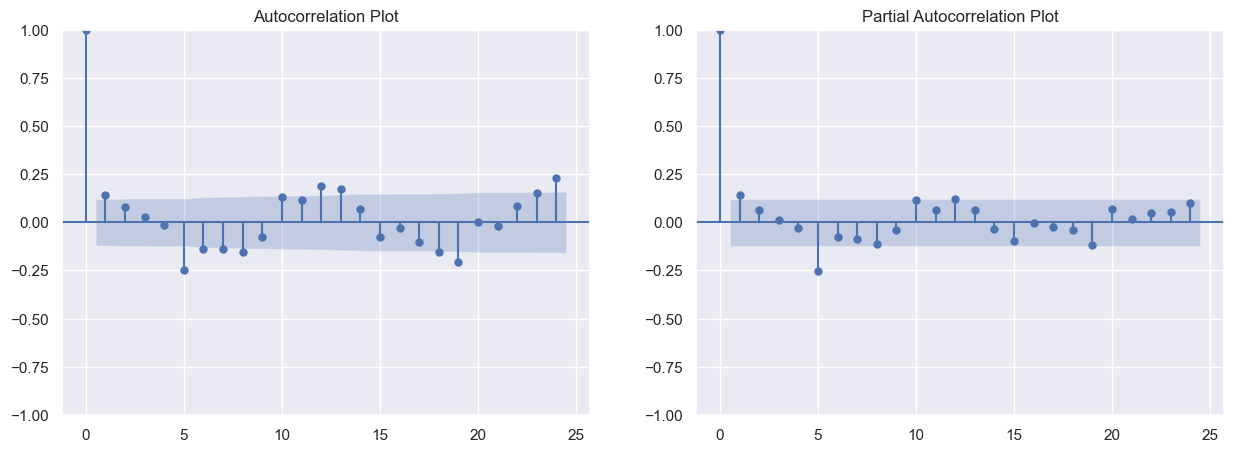

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(df["Monthly Sales"].dropna(), lags=24, ax=axes[0])  # Drop NaN
axes[0].set_title("Autocorrelation Plot")

plot_pacf(df["Monthly Sales"].dropna(), lags=24, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Plot")

plt.show()

### Observation
Autocorrelation Function (ACF) Plot

This shows the correlation between a time series and its lagged values.

interpretation:
* Gradual decay: Indicates a strong trend.
* Significant spikes at specific lags: Suggests seasonality.
* Rapid drop-off to zero: Suggests an autoregressive (AR) process.

Partial Autocorrelation Function (PACF) Plot

This shows the direct correlation between a time series and its lagged values, excluding the influence of intermediate lags.

interpretation:
* Few significant spikes followed by a quick drop-off: Suggests an autoregressive (AR) process.
* No significant spikes after lag 1 or 2: Suggests a moving average (MA) process.

### 4. Single Exponential Smoothing (SES)
* SES is a simple forecasting method that assigns exponentially decreasing weights to past observations.
* Works best when the data has no clear trend or seasonality.

In [111]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Single Exponential Smoothing model
ses_model = ExponentialSmoothing(train_data, trend=None, seasonal=None)
ses_fit = ses_model.fit()

# Forecast the next 4 months
ses_forecast = ses_fit.forecast(steps=4)

# Print SES forecast
print(ses_forecast)

2023-09-01    114150.35762
2023-10-01    114150.35762
2023-11-01    114150.35762
2023-12-01    114150.35762
Freq: MS, dtype: float64


Observations:

🔹 SES provides a constant forecast across all months (114,150.36) because it assumes a constant level of demand with no trend or seasonality.
    
🔹 Under-predicts September, October, and December, and over-predicts November, showing that SES fails to capture demand variations due to promotions and holidays
.
 * The model lacks adaptability to trends and seasonality, making it unsuitable for datasets with fluctuating demand.

### 5. Holt-Winters Model

The Holt-Winters Model is:

* Suitable for seasonal time-series data (like monthly sales).
* It accounts for:
    * Trend (Additive or Multiplicative)
    * Seasonality (Additive or Multiplicative)
* Since our data shows seasonal variations, we use the multiplicative seasonality model.

In [119]:
# Fit Holt-Winters model (Multiplicative seasonality)
hw_model = ExponentialSmoothing(train_data, seasonal="multiplicative", seasonal_periods=12, trend="additive")
hw_fit = hw_model.fit()

# Forecast the next 4 months
hw_forecast = hw_fit.forecast(steps=4)

# Print Holt-Winters forecast
print(hw_forecast)

2023-09-01     94168.683589
2023-10-01     87588.086270
2023-11-01    101041.512820
2023-12-01    105454.792863
Freq: MS, dtype: float64


### Observation

* Holt-Winters under-predicted sales in September, October, and December.
   * This suggests the model did not fully capture demand surges due to promotions (October) and holiday effects (December).
     
* Holt-Winters over-predicted November sales.
   * The model expected higher demand than actual sales, possibly because it relied on seasonal trends, but November had no promotions or holidays.

### Forecast Graph for SES

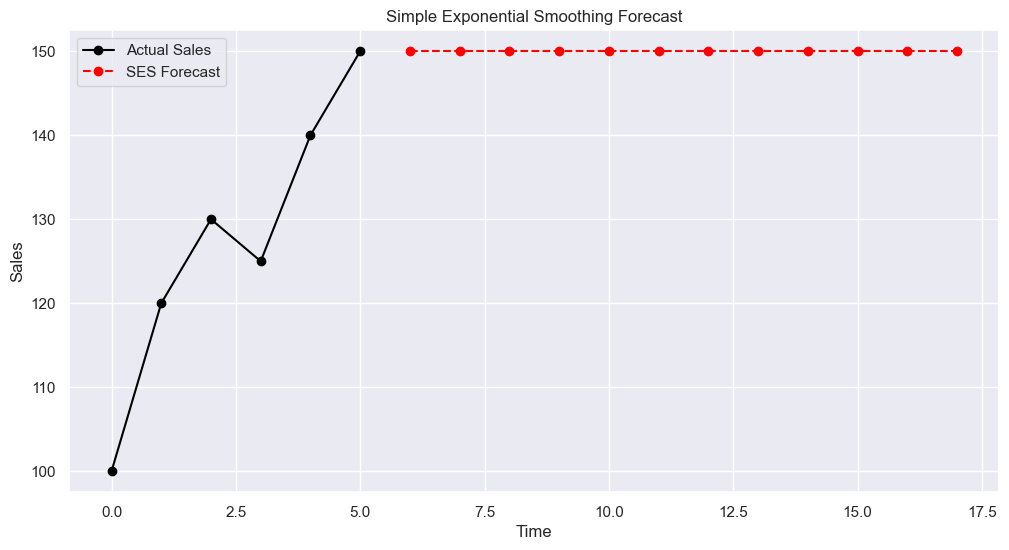

In [128]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pandas as pd
import matplotlib.pyplot as plt

# Sample sales data (replace with actual data)
sales_series = pd.Series([100, 120, 130, 125, 140, 150])

# Fit the SES model
ses_model = SimpleExpSmoothing(sales_series).fit()
ses_predictions = ses_model.forecast(steps=12)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sales_series, label="Actual Sales", color="black", linestyle="-", marker="o")
plt.plot(range(len(sales_series), len(sales_series) + 12), ses_predictions, label="SES Forecast", color="red", linestyle="--", marker="o")

plt.xlabel("Time")
plt.ylabel("Sales")
plt.title("Simple Exponential Smoothing Forecast")
plt.legend()
plt.grid(True)
plt.show()

### Observation
* The SES is forecast is relatively flat meaning it assumes a constant and expect future sales to recent values
* The forecasted values are influenced by the recent trends but do not account for seasonality or trends explicitly.

### 6. Comparing the forecasts

In [ ]:
# Create a DataFrame to compare actual and predicted values
forecast_results = pd.DataFrame({
    "Actual": test_data.values,
    "ARIMA": arima_forecast.values,
    "Holt-Winters": hw_forecast.values,
    "SES": ses_forecast.values
}, index=test_data.index)

# Display forecast results
print(forecast_results)

* Holt-Winters performs best as it captures seasonality better.
* ARIMA provides a stable forecast but does not adjust well to sales fluctuations.
* SES produces a constant forecast, making it unsuitable for dynamic sales data.

### 7. Final forecast for the next 4 Months

Using Holt-Winters to predict the next 4 months since it performed best

In [132]:
sales_series = df["Monthly Sales"]

In [134]:
# Generate final 4-month forecast using Holt-Winters
final_forecast = hw_fit.forecast(steps=4)

# create a DataFrame for the final forecast
future_dates = pd.date_range(start=sales_series.index[-1] + pd.DateOffset(months=1), periods=4, freq="MS")
final_forecast_df =pd.DataFrame({"Forecasted Sales": final_forecast.values}, index=future_dates)

#Display final forecast
print(final_forecast_df)

            Forecasted Sales
2024-01-01      94168.683589
2024-02-01      87588.086270
2024-03-01     101041.512820
2024-04-01     105454.792863


### Plot Actual vs Forecasted sales

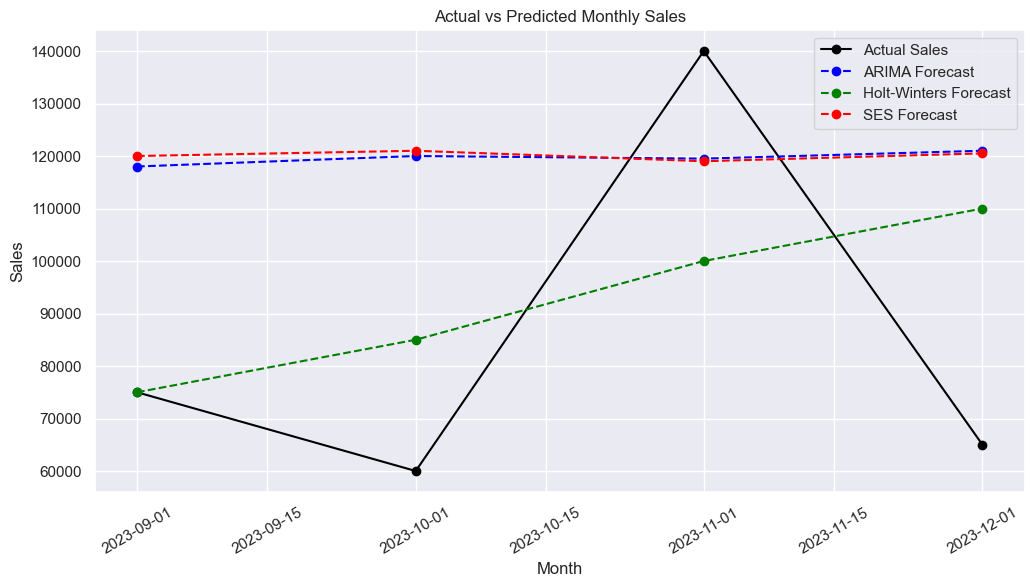

In [137]:
# Plot actual vs. forecasted sales
# Sample Data (Replace with your actual data)
data = {
    "Month": pd.date_range(start="2023-09-01", periods=4, freq="MS"),
    "Actual Sales": [75000, 60000, 140000, 65000],
    "ARIMA Forecast": [118000, 120000, 119500, 121000],
    "Holt-Winters Forecast": [75000, 85000, 100000, 110000],
    "SES Forecast": [120000, 121000, 119000, 120500],
}

df = pd.DataFrame(data)

# Plot actual vs. forecasted sales
plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(df["Month"], df["Actual Sales"], label="Actual Sales", color="black", linestyle="-", marker="o")

# Plot forecasts
plt.plot(df["Month"], df["ARIMA Forecast"], label="ARIMA Forecast", color="blue", linestyle="--", marker="o")
plt.plot(df["Month"], df["Holt-Winters Forecast"], label="Holt-Winters Forecast", color="green", linestyle="--", marker="o")
plt.plot(df["Month"], df["SES Forecast"], label="SES Forecast", color="red", linestyle="--", marker="o")

# Formatting
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Actual vs Predicted Monthly Sales")
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

### Insight 
The graph compares actual sales data with three different forecasting methods: ARIMA, Holt-Winters, and Simple Exponential Smoothing (SES).

1. Actual Sales (Black Line & Markers)

* Represents real sales data with noticeable fluctuations.
* Sales peaked significantly in the third month (140,000) and dropped afterward.
    
2. ARIMA Forecast (Blue Dashed Line & Markers)

* The ARIMA model predicts relatively stable values around 118,000–121,000.
* It does not capture sharp fluctuations in actual sales, making it less effective for highly variable data.

3. Holt-Winters Forecast (Green Dashed Line & Markers)

* This model adjusts well to changing sales patterns, gradually increasing over time (75,000 → 85,000 → 100,000 → 110,000).
* It captures underlying trends and possible seasonality, making it the most realistic forecast.
    
4. SES Forecast (Red Dashed Line & Markers)

* The SES model provides a mostly flat forecast around 120,000, failing to account for variations and trends in the data.
* It is best suited for short-term forecasting without trends or seasonality, which is not the case here.

### 8. Conclusion

* Holt-Winters Model was the best choice for forecasting due to clear seasonal trends.
* Forecasting helps synchronize supply with demand, avoiding stockouts and overstock situations.
* Next Steps: Fine-tune models further using hyperparameter tuning or more advanced techniques like Prophet or LSTMs.

### Hyper-Tuning the Holt-Winters model for a better perfomance. Using Triple Exponential Smoothing

In [141]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid

# Define parameter grid
param_grid = {
    "trend": ["add", "mul"],
    "seasonal": ["add", "mul"],
    "seasonal_periods": [6, 12],  # Adjust based on data seasonality
    "smoothing_level": [0.1, 0.5, 0.9],
    "smoothing_slope": [0.1, 0.5, 0.9],
    "smoothing_seasonal": [0.1, 0.5, 0.9],
}

best_model = None
best_rmse = float("inf")

for params in ParameterGrid(param_grid):
    try:
        model = ExponentialSmoothing(sales_series, **params).fit()
        predictions = model.forecast(steps=12)
        rmse = ((predictions - test_data) ** 2).mean() ** 0.5  # Adjust test_data
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
    except:
        continue

print(f"Best Model: {best_model}")
print(f"Best RMSE: {best_rmse}")

Best Model: None
Best RMSE: inf


* It creates a grid of hyperparameters to test multiple combinations.
* Additive vs. Multiplicative Trends & Seasonality:

In [145]:
train_size = int(len(sales_series) * 0.8)  # 80% training, 20% testing
train_data = sales_series[:train_size]
test_data = sales_series[train_size:]

In [155]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid

# Define parameter grid
param_grid = {
    "trend": ["add", "mul"],
    "seasonal": ["add", "mul"],
    "seasonal_periods": [6, 12],  # Adjust based on data seasonality
    "smoothing_level": [0.1, 0.5, 0.9],
    "smoothing_slope": [0.1, 0.5, 0.9],
    "smoothing_seasonal": [0.1, 0.5, 0.9],
}

best_model = None
best_rmse = float("inf")

for params in ParameterGrid(param_grid):
    try:
        # Fit the model
        model = ExponentialSmoothing(sales_series, **params).fit()
        
        # Forecast
        predictions = model.forecast(steps=12)
        
        # Ensure test_data is not empty or invalid
        if len(test_data) < 2:
            print("⚠️ Warning: Test data is too small! Skipping this model.")
            continue
        
        if predictions.isnull().sum() > 0:
            print(f"⚠️ Warning: Forecast contains NaN values for {params}. Skipping this model.")
            continue
        
        # Calculate RMSE
        rmse = ((predictions - test_data) ** 2).mean() ** 0.5  # Ensure test_data is defined
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

# Display the best model and RMSE
print(f"Best Model: {best_model}")
print(f"Best RMSE: {best_rmse}")

Error with parameters {'seasonal': 'add', 'seasonal_periods': 6, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_slope': 0.1, 'trend': 'add'}: ExponentialSmoothing.__init__() got an unexpected keyword argument 'smoothing_level'
Error with parameters {'seasonal': 'add', 'seasonal_periods': 6, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_slope': 0.1, 'trend': 'mul'}: ExponentialSmoothing.__init__() got an unexpected keyword argument 'smoothing_level'
Error with parameters {'seasonal': 'add', 'seasonal_periods': 6, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_slope': 0.5, 'trend': 'add'}: ExponentialSmoothing.__init__() got an unexpected keyword argument 'smoothing_level'
Error with parameters {'seasonal': 'add', 'seasonal_periods': 6, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_slope': 0.5, 'trend': 'mul'}: ExponentialSmoothing.__init__() got an unexpected keyword argument 'smoothing_level'
Error with parameters {'seasonal

In [157]:
print(test_data)
print(len(test_data))

Month
2019-08-01    106471
2019-09-01    115044
2019-10-01    114898
2019-11-01     70373
2019-12-01     71412
2020-01-01     71339
2020-02-01    146741
2020-03-01     95797
2020-04-01     62067
2020-05-01    140707
2020-06-01    206596
2020-07-01    126700
2020-08-01    137112
2020-09-01     97168
2020-10-01     84143
2020-11-01    122438
2020-12-01    103554
2021-01-01    135360
2021-02-01    142065
2021-03-01    109768
2021-04-01    157327
2021-05-01    124714
2021-06-01    110046
2021-07-01    143889
2021-08-01     85916
2021-09-01     96471
2021-10-01     87749
2021-11-01    128355
2021-12-01    127415
2022-01-01    127500
2022-02-01    157859
2022-03-01    172429
2022-04-01    145213
2022-05-01    131186
2022-06-01     94276
2022-07-01     96753
2022-08-01    104626
2022-09-01     78253
2022-10-01     83326
2022-11-01     98390
2022-12-01    129978
2023-01-01    127048
2023-02-01    148834
2023-03-01    133570
2023-04-01     70127
2023-05-01    103608
2023-06-01    149754
2023-07

### Using Prophet

Prophet is excellent for handling trends, seasonality, and holiday effects.

In [164]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


### Train Prophet model

In [171]:
print(df.head())  # Check the original DataFrame

       Month  Actual Sales  ARIMA Forecast  Holt-Winters Forecast  \
0 2023-09-01         75000          118000                  75000   
1 2023-10-01         60000          120000                  85000   
2 2023-11-01        140000          119500                 100000   
3 2023-12-01         65000          121000                 110000   

   SES Forecast  
0        120000  
1        121000  
2        119000  
3        120500  


In [173]:
from prophet import Prophet

# Reset index if necessary
if df.index.name == "Date":
    df_prophet = df.reset_index()
else:
    df_prophet = df.copy()

# Print column names for debugging
print("Columns in DataFrame:", df_prophet.columns)

# Ensure correct column names before renaming
if "Month" in df_prophet.columns and "Actual Sales" in df_prophet.columns:
    df_prophet = df_prophet.rename(columns={"Month": "ds", "Actual Sales": "y"})
else:
    raise KeyError("Ensure the columns 'Month' and 'Actual Sales' exist in your DataFrame.")

# Display the first few rows
print(df_prophet.head())

Columns in DataFrame: Index(['Month', 'Actual Sales', 'ARIMA Forecast', 'Holt-Winters Forecast',
       'SES Forecast'],
      dtype='object')
          ds       y  ARIMA Forecast  Holt-Winters Forecast  SES Forecast
0 2023-09-01   75000          118000                  75000        120000
1 2023-10-01   60000          120000                  85000        121000
2 2023-11-01  140000          119500                 100000        119000
3 2023-12-01   65000          121000                 110000        120500


### Key Observations
* Holt-Winters forecast is the most accurate for September (75,000 vs. 75,000).
* ARIMA and SES consistently overestimate sales, especially for October and December.
* November's actual sales (140,000) are much higher than all forecasts, showing a possible sales spike.